In [6]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from preprocessing_sequencing import preprocess_sequences as ps
import os
from matplotlib.colors import LogNorm
%matplotlib inline
import yaml
from collections import Counter
from math import log
from datetime import datetime
from scipy.stats import ttest_rel
import figure_formatting as ff
%matplotlib inline


In [3]:

with open("general_analysis_parameters.yaml", "r") as file:
    gen_parameters = yaml.safe_load(file)
rcParams['font.sans-serif'] = gen_parameters['font']
rcParams['font.family'] = gen_parameters['font']
rcParams['font.size'] = gen_parameters['font_size']
font_size = gen_parameters['font_size']
saving_path = gen_parameters['fig_saving_path']
mice = gen_parameters['MICE']
proj_path = gen_parameters['proj_path']

In [4]:

# mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
negs_dict = {}

for mouse in mice:
    parameters_path = pathlib.Path(f"{proj_path}/{mouse}/Sequencing")
    parameters = ps.load_parameters(directory=str(parameters_path))
    barcodes_across_sample = pd.read_pickle(
        str(parameters_path / "final_processed_sequences/barcodes_across_sample.pkl")
    )
    max_y = 100
    rcParams["figure.figsize"] = (8, 5)
    interpolate_on_x = len(np.flip(np.sort(barcodes_across_sample.sum(axis=1)))) - len(
        np.flip(np.sort(barcodes_across_sample.sum(axis=1)))[
            np.flip(np.sort(barcodes_across_sample.sum(axis=1))) < max_y
        ]
    )
    filtered_barcodes = barcodes_across_sample[barcodes_across_sample.sum(axis=1) >= max_y]
    negative_samples = parameters['negative_control_samples']
    negs_dict[mouse] = filtered_barcodes[negative_samples].melt(
        var_name="samples", value_name="barcode_counts")

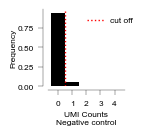

In [28]:
import matplotlib.ticker as mticker

dist_list = []
for mouse, df in negs_dict.items():
    dist = df.loc[df["barcode_counts"] > 0, "barcode_counts"].value_counts()
    dist_list.append(dist)
total_distribution = pd.concat(dist_list, axis=1).fillna(0).sum(axis=1)
total_distribution = total_distribution.sort_index()
total_distribution_norm = total_distribution / total_distribution.sum()
fig, axes = plt.subplots(figsize=(1, 1))
ax = total_distribution_norm.plot(kind="bar", width=1, color='black')  
ax.axvline(x=0.5, color='red', linestyle='dotted', linewidth=1, label='cut off')
# plt.xlabel(f"UMI Counts\nNegative control")
# plt.ylabel("Frequency")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), frameon=False,)
plt.xticks(rotation=90)
ff.myPlotSettings_splitAxis(fig=fig, ax=axes, ytitle= "Frequency", xtitle=f"UMI Counts\nNegative control", title='', mySize =font_size)
axes.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.show()
fig.savefig(f"{saving_path}/supplementary/extended_data_fig_1_neg_control.svg", format="svg")

Paired t-test result: t-statistic = 4.8339, p-value = 0.0084


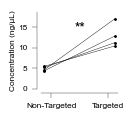

In [38]:
#load excel file recording results of non-targeted versus targeted second strand synthesis approach
ssynth = pd.read_excel(f'{proj_path}/second_str_synth_results_120122.xlsx')
non_targeted = ssynth['Non-targeted']
targeted = ssynth['Targeted']
t_stat, p_value_two_tailed = ttest_rel(targeted, non_targeted)
if t_stat > 0:
    p_value_one_tailed = p_value_two_tailed / 2
else:
    p_value_one_tailed = 1 - (p_value_two_tailed / 2)

print(f"Paired t-test result: t-statistic = {t_stat:.4f}, p-value = {p_value_one_tailed:.4f}")
fig, axes = plt.subplots(figsize=(1, 1))
x_positions = [1, 2]  # '1' for non-targeted, '2' for targeted

for i in range(len(non_targeted)):
    plt.plot(x_positions, [non_targeted[i], targeted[i]], color='black', marker='o', markersize=0.2, linewidth=0.3)
plt.scatter(np.ones(len(non_targeted)), non_targeted, color='black', label='Non-Targeted', s=1)
plt.scatter(np.ones(len(targeted)) * 2, targeted, color='black', label='Targeted', s=1)

plt.xticks([1, 2], ['Non-Targeted', 'Targeted'])
if p_value_one_tailed < 0.01:
    max_y = max(max(non_targeted), max(targeted)) 
    #plt.plot([1, 2], [max_y * 1.1, max_y * 1.1], color='black', linestyle='-', linewidth=1)
    plt.text(1.5, max_y*0.8, '**', fontsize=10, ha='center')
plt.ylim(0, max_y * 1.1)
plt.xticks([1.1, 1.9], ['Non-Targeted', 'Targeted'])
ff.myPlotSettings_splitAxis(fig=fig, ax=axes, ytitle= "Concentration (ng/μL)", xtitle="", title='', mySize =font_size)
plt.show()
fig.savefig(f"{saving_path}/supplementary/extended_data_fig_1_second_strand_synth_approach.svg", format="svg")

In [ ]:
#if you haven't already - run this to combine all raw tables for template switching fig:
ps.combine_tables_for_supp_fig(mice=mice, proj_path=proj_path, use_slurm=True,
            slurm_folder='/camp/home/turnerb/slurm_logs')

In [39]:
switching_tab = pd.read_pickle(f"{proj_path}/switching_tab_combined.pkl")
template_switches = switching_tab[switching_tab["different_neurons"] > 1]
# calculate shannon entropy for umi's to see if it might be bias for low complexity sequences
s = lambda i: -sum(f * log(f, 2) for f in ((j / len(i)) for j in Counter(i).values()))
template_switches["entropy"] = template_switches["UMI"].apply(s)
template_switches["relative_abundance"] = (
    template_switches["1st_abundant"] / template_switches["2nd_abundant"]
)
# calculate AT content
AT_calc = lambda x: (x.count("A") + x.count("T")) / len(x)
template_switches["AT_content"] = template_switches["UMI"].apply(AT_calc)

/tmp/ipykernel_2365400/2643430392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  template_switches["entropy"] = template_switches["UMI"].apply(s)
/tmp/ipykernel_2365400/2643430392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  template_switches["relative_abundance"] = (
/tmp/ipykernel_2365400/2643430392.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

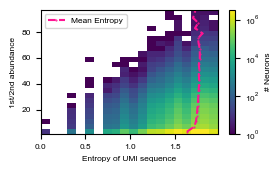

In [53]:

df = pd.DataFrame(template_switches)
fig, ax1 = plt.subplots(figsize=(2.8, 1.7))
hist = ax1.hist2d(
    df["entropy"],
    df["relative_abundance"],
    norm=LogNorm(),
    bins=(20, np.arange(1, 100, 4))
)

plt.colorbar(hist[3], ax=ax1, label="# Neurons")  

ax1.set_xlabel("Entropy of UMI sequence")
ax1.set_ylabel("1st/2nd abundance")
#ax1.set_title("Entropy")

y_bins = np.arange(1, 100, 4)
df['bin'] = np.digitize(df["relative_abundance"], y_bins)
grouped = df.groupby('bin').agg(count=('entropy', 'size'), median_entropy=('entropy', 'mean'))
medians_to_plot = []
y_bin_centers = []

for bin_index, row in grouped.iterrows():
    if row['count'] > 5:  # Only consider bins with 3 or more data points
        y_center = y_bins[bin_index - 1] + np.diff(y_bins)[0] / 2  # Center of the bin
        medians_to_plot.append(row['median_entropy'])
        y_bin_centers.append(y_center)


ax1.plot(medians_to_plot, y_bin_centers, color='deeppink', markersize=0.5, marker='o', linestyle='--', label='Mean Entropy')
ax1.legend(loc='upper left', frameon=True)

plt.tight_layout()
plt.show()
fig.savefig(f"{saving_path}/supplementary/extended_data_fig_1_entropy.svg", format="svg")

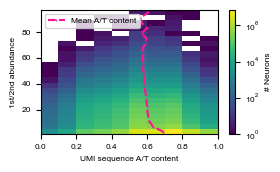

In [52]:
df = pd.DataFrame(template_switches)
fig, ax1 = plt.subplots(figsize=(2.8, 1.7))

hist = ax1.hist2d(
    df["AT_content"],
    df["relative_abundance"],
    norm=LogNorm(),
    bins=(10, np.arange(1, 100, 4))
)

plt.colorbar(hist[3], ax=ax1, label="# Neurons")  
ax1.set_xlabel("UMI sequence A/T content")
ax1.set_ylabel("1st/2nd abundance")
#ax1.set_title("UMI AT content")
y_bins = np.arange(1, 100, 4)
df['bin'] = np.digitize(df["relative_abundance"], y_bins)
grouped = df.groupby('bin').agg(count=('AT_content', 'size'), median_AT_content=('AT_content', 'mean'))
medians_to_plot = []
y_bin_centers = []
for bin_index, row in grouped.iterrows():
    if row['count'] > 5:  # Only consider bins with 3 or more data points
        y_center = y_bins[bin_index - 1] + np.diff(y_bins)[0] / 2  
        medians_to_plot.append(row['median_AT_content'])
        y_bin_centers.append(y_center)
ax1.plot(medians_to_plot, y_bin_centers, color='deeppink', markersize=0.5, marker='o', linestyle='--', label='Mean A/T content')
ax1.legend(loc='upper left', frameon=True)

plt.tight_layout()
plt.show()
fig.savefig(f"{saving_path}/supplementary/extended_data_fig_1_AT_content.svg", format="svg")